# Les proccessus à hétéroscédasticités conditionnelle: ARCH et GARCH

## Introduction

Les processus à hétéroscédasticités conditionnelle sont utilisés pour caractériser des séries chronologiques. Ils ont été introduit par Robert F.Engle en 1982 pour palier aux modèles classiques comme les ARIMA, SARIMA. Pourquoi ? Parce que ces derniers ont des difficultés à bien modéliser ce qu'on appelle la volatilité. 

#### Qu'est ce que la volatilité ?

Prenons un exemple avec un actif financier. La volatilité de cet actif est un indicateur de la dispersion de ses rendements par rapport à ça moyenne sur une période de temps donnée. On voit donc naître la notion de variance.

La volatilité de cet actif sera d’autant plus forte que les cours des marchés sont instables. La volatilité permet donc de mesurer le risque : plus la volatilité d’un produit est grande, plus fort est le risque associé à ce produit. Ce qui est normal, si le prix d’un produit varie beaucoup, on n’est pas sûr de pouvoir le revendre avec profit ou même sans perte.

Plusieurs modèles existent, mais nous nous interresserons dans ce projet aux modèles ARCH et GARCH. On travaillera dans un premier temps sur les bien fondé de ces modèles en introduisant leur construction et vérifiant leur stationnarité. On montrera en quoi les modèles simples comme les ARMA ne sont pas approprié et enfin nous illustrerons sur plusieurs jeu de données comportant de fortes volatilités afin de comprendre dans quelle mesure ces modèles à hétéroscédasticités conditionnelle sont capables de reproduire ces phénomènes. 

## Plan

- I. Les biens fondés des modèles ARCH et GARCH
a) Stationarité
b) Variances conditionnelle
c) ARMA vs ARCH
- II.  Exemples
a) Court banque argentine
b) 

## I. Les biens fondés des modèles ARCH et GARCH

On se propose tout d'abord de mettre en évidence les différences de variances entre un processus classique $AR(1)$ et un processus $AR-ARCH(1)$.

In [2]:
# On importe quelques outils pour les SARIMA, ACF/PACF, tests usuels, ...
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import datetime as dt
import scipy as sp 

In [3]:
def produit_vectoriel(a, b):
    c=[]
    for i in range(len(a)):
        c.append(a[i]*b[i])
    return c


def simuler_arma(n, m, Phi, Theta, s2):
    e=np.random.randn(n)*(s2**(1/2))

    p=len(Phi)
    q=len(Theta)
    r=max(p,q)

    y=[0 for i in range(n)]

    for i in range(n-r):
        if p>0:
            ar=sum(produit_vectoriel(Phi,y[i:(i+1)]))
        else: ar=0 

        if q>0:
            ma=sum(produit_vectoriel(Theta,y[i:(i+1)]))
        else: ma=0

        y[i]=ar + ma + e[i]

    y=[y[i]+m for i in range(len(y))]

    return y


def simuler_ar_arch(n, m, Phi, alpha,s2):
    e=np.random.randn(n)*(s2**(1/2))

    p=len(Phi)
    y=[0 for i in range(n)]
    t=np.zeros(n)
    t[0]=np.random.randn(1)*(alpha[0]/(1-alpha[1]))**(1/2)
    for i in range(1,n):
        t[i]=e[i]*(alpha[0]+alpha[1]*t[i-1]**2)**(1/2)
    
    for i in range(n-p):
        if p>0:
            arch=sum(produit_vectoriel(Phi,y[i:(i+1)]))
        else: arch=0 

        y[i]=arch + t[i]

    y=[y[i]+m for i in range(len(y))]

    return y


def simuler_arch(n, m, Phi, alpha,s2):
    e=np.random.randn(n)*(s2**(1/2))

    p=len(Phi)
    y=[0 for i in range(n)]
    t=np.zeros(n)
    t[0]=np.random.randn(1)*(alpha[0]/(1-alpha[1]))**(1/2)
    for i in range(1,n):
        t[i]=e[i]*(alpha[0]+alpha[1]*t[i-1]**2)**(1/2)

        y[i]=t[i]

    y=[y[i]+m for i in range(len(y))]

    return y

Text(0.5, 1.0, 'AR(1)')

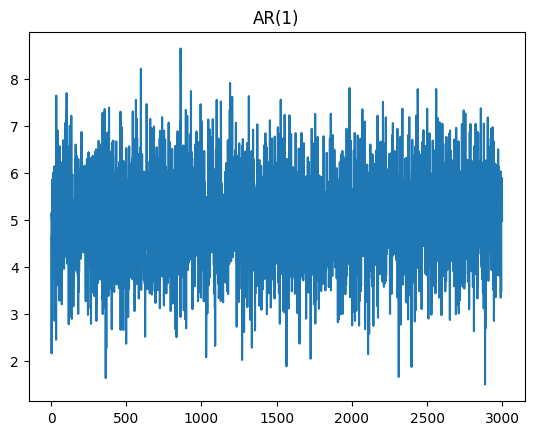

In [4]:
ary=simuler_arma(4000,5,[0.3],[],1)[1000:]
x=[i for i in range(3000)]
plt.plot(x, ary) 
plt.title("AR(1)")

Text(0.5, 1.0, 'ARCH(1)')

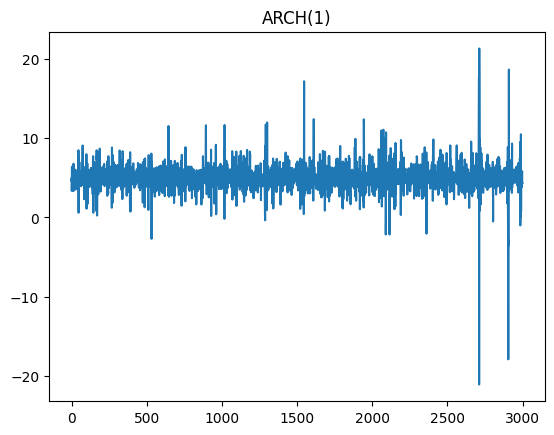

In [5]:
x=[i for i in range(3000)]
arch1=simuler_arch(4000,5,[0.3],[0.5,0.9],1)[1000:]
plt.plot(x,arch1)
plt.title("ARCH(1)")

Text(0.5, 1.0, 'AR(1)-ARCH(1)')

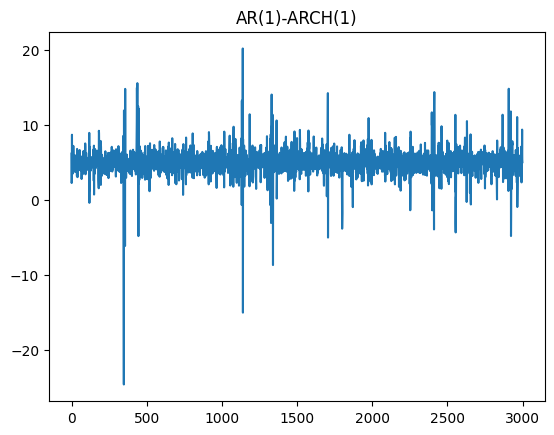

In [6]:
x=[i for i in range(3000)]
arch1=simuler_ar_arch(4000,5,[0.3],[0.5,0.9],1)[1000:]
plt.plot(x,arch1)
plt.title("AR(1)-ARCH(1)")

Comme on peut le voir, le processus hétéroscédastique possède des pics bien plus variable que le processus $AR(1)$. Il suffit également de voir la différence d'échelle sur l'axe y. Ainsi, nous pouvons déjà déduire visuellement qu'un processus classique telle que les ARMA, ne sont plus interressant pour modéliser des séries à forte volatilité.

Regardons maintenant la stationnarité de ces processus à hétéroscédasticité conditionnelle.

### I.1 Définitions et stationarité

Pour commencer, redéfinissons un bruit blanc et un processus stationnaire. 

#### Bruit blanc

On appelle bruit blanc fort, tout processus $(X_t)_{t \in T}$ de variable indépendantes et identiquement distribuées. 

Un bruit blanc (faible) quand à lui correspond à tout processus $(X_t)_{t \in T}$ de variable non corrélées, de même espérance $m$ et de même variance $\sigma^2$ finie. On a alors :

$$\forall t \in T, \quad E[X_t]\text{ }=\text{ }m \quad \text{et } \forall (t,s) \in T^2, \quad Cov(X_t,X_s)\text{ }= \text{ } \left\{
    \begin{array}{ll}
        \sigma^2 & \text{si t=s} \\
        0 & \text{sinon}
    \end{array}
\right.$$


Par la suite, il sera précisé quand nous parlerons de bruit blanc fort. Autrement, la notion de bruit blanc sera considéré au sens faible. Maintenant que nous avons redéfinit ce qu'est un bruit blanc, redéfinissons maintenant un processus stationnaire.

#### Processus stationaire

Une série chronologique est dite stationnaire (au second ordre) si sa moyenne et sa covariance sont invariante pour tout décalage de temps. Autrement dit :

- $ \forall t \in \mathbb{Z} \quad E[X_t]=m $
- $\forall (t,s) \in T^2 \text{ et pour tout décalage temporel } k \in \mathbb{Z} \quad \Gamma(t,s) \text{ } = \text{ }\Gamma(t+k,s+k)$

Maintenant que nous avons redéfinit ce qu'est la stationarité, étudions donc maintenant la stationarité des modèles à hétéroscédasticité conditionnelle. Mais tout d'abord, définissons ces modèles. Nous allons donc définir le modèle ARCH pour ce projet. Un modèle $X_t$ est dit autoregressif conditionnellement hétéroscédastique d'ordre 1 que l'on note $ARCH(1)$, s'il admet l'écriture suivante :

$$ X_t \quad = \quad \epsilon _t h_t $$

avec $h_t^2 = \omega + \alpha _1 X_{t-1}^2$ et $\epsilon _t \sim \mathcal{N}(0,1)$ un bruit blanc fort. Et pour le processus GARCH (ARCH Généralisé) :

$$ X_t \quad = \quad \epsilon _t h_t $$

avec $h_t^2 = \omega + \alpha _1 X_{t-1}^2 + \beta _1 \epsilon _{t-1}^2$ et $\epsilon _t \sim \mathcal{N}(0,1)$ un bruit blanc fort.

Etudions donc maintenant la stationnarité.

#### Stationarité

Nous considérerons que nos modèles sont centrés en 0. Pour la modélisation ARCH, nous avons :

$$\begin{align}
E[X_t] \quad & = \quad E[\epsilon _t] E[h_t] \text{ par indépendance} \\
& = \quad 0
\end{align} $$

Regardons également la variance :

$$\begin{align}
Var(X_t) \quad & = \quad E[X_t^2] \\
& = \quad E[\epsilon _t^2] \text{ } E[h_t^2] \\
& = \quad \omega + \alpha _1 \text{ } E[X_{t-1}^2] \\
& = \quad \omega + \alpha _1 \text{ } (\omega + \alpha _1 \text{ } E[X_{t-2}^2]) \\
& = \quad ... \\
& = \quad \omega \text{ } + \text{ } \omega \text{ } \sum_{k\ge 1} \text{ } \alpha _1^k \text{ } \text{ } + \text{ } \prod_{k \ge 1} \text{ } \alpha _1^k E[X_{t-k}^2] \\
& = \quad \frac{\omega}{1-\alpha _1} \quad \text{ par somme d'une suite géométrique si } 0<\alpha _1<1 
\end{align}$$

et on en déduit alors la covariance :

$$\begin{align}
E[X_t \text{ } X_{t+k}] \quad & = \quad E[\epsilon _t h_t \text{ } \epsilon _{t+k} h_{t+k}] \\
& = \quad E[\epsilon _t \epsilon _{t+k}] \text{ } E[h_t h_{t+k}] \\
& = \quad E[\epsilon _t \epsilon _{t+k}] \text{ } E[\text{ }\sqrt{\omega + \alpha _1 X_{t-1}^2} \text{ } \sqrt{\omega + \alpha _1 X_{t-1+k}^2} \text{ }]\\
& = \quad \left\{
    \begin{array}{ll}
        \frac{\omega}{1-\alpha _1} & \text{si k=0} \\
        0 & \text{sinon}
    \end{array}
\right.
\end{align}$$

Avec k=0, on obtient la variance du processus. Ainsi, la covariance ne dépend pas du temps, on a donc bien un processus stationnaire. On peut même remarquer que ce dernier ce comporte comme un bruit blanc

Maintenant que la stationarité de ces processus a été établi, montrons la différence de variance conditionnelle.

### I.2 Démonstration

#### a. Variance conditionnelle constante dans le cas d'un AR(1)

Soit le processus $(X_t)_{t\in \mathbb{Z}}$ une série chronologique suivant un $AR(1)$. On a alors :

$$\forall t\in \mathbb{Z} \quad  X_t = \theta X_{t-1} + \epsilon _t$$

Avec $\epsilon _t \sim \mathcal{N}(0,1)$ un bruit blanc. Passons à l'espérance conditionnelle, on en aura besoin pour connaître la variance conditionnelle :

$$\begin{align}
E[X_t|X_{t-1}] \quad &= \quad E[\theta X_{t-1} + \epsilon _t | X_{t-1}] \\
& = \quad E[\theta X_{t-1}|X_{t-1}] + E[\epsilon _t|X_{t-1}] \quad \text{ par linéarité de l'espérance} \\
& = \quad \theta X_{t-1} + E[\epsilon _t]  \quad \text{par indépandance entre } \epsilon _t \text{ et } X_{t-1} \\
& = \quad \theta X_{t-1}
\end{align} $$

On a alors l'expression de $E[X_t|X_{t-1}]$. Maintenant regardons la variance conditionnelle. L'expression de la variance conditionnelle est la suivante :

$$\begin{align}
Var(X_t|X_{t-1}) \quad & = \quad E[(X_t-E[X_t|X_{t-1}])^2|X_{t-1}] \\
& = \quad E[\text{ } (\theta X_{t-1} + \epsilon _t \quad - \quad \theta X_{t-1} )^2\quad | X_{t-1}] \\
& = \quad E[\text{ }\epsilon _t^2 \text{ } | \text{ }X_{t-1}] \\
& = \quad E[\text{ }\epsilon _t^2 \text{ }] \\
& = \quad \sigma ^2
\end{align} $$

Donc on a une variance conditionnelle constante ici. Regardons ce qu'il en est pour un processus ARCH.

#### b. Variance conditionnelle non constante dans le cas d'un processus ARCH(1)

Prenons un modèle $ARCH(1)$ dont on rappelle l'écriture :

$$ X_t \quad = \quad \epsilon _t h_t $$

avec $h_t^2 = \alpha _0 + \alpha _1 X_{t-1}^2$ et $\epsilon _t \sim \mathcal{N}(0,1)$ un bruit blanc fort.

On veut montrer que $ Var(X _t \text{ } | X_{t-1},...,X_{t-k})$ n'est pas constante. On notera par la suite $I_{t-k} = X_{t-1}, ..., X_{t-k} $ comme étant l'ensemble de l'information au passée pour tout $k \in \mathbb{N}^*$. On sait que :

$$\begin{align}
Var(X_t\text{ }| \text{ } I_{t-k}) \quad & = \quad E[X_t^2 \text{ }|\text{ } I_{t-k}] \quad - \quad (E[X_t \text{ }|\text{ } I_{t-k}])^2 \\
& = \quad E[\text{ } \epsilon _t^2 \text{ } (\alpha _0 + \alpha _1 X_{t-1}^2) \text{ } | \text{ } I_{t-k}\text{ }] \quad - \quad E[\text{ } \epsilon _t h_t \text{ } | \text{ } I_{t-k}\text{ }]^2 \quad \quad \text{ par indépendance de } \epsilon _t^2 \\
& = \quad E[\text{ } \epsilon _t^2 \text{ }] E[\text{ } (\alpha _0 + \alpha _1 X_{t-1}^2) \text{ } | \text{ } I_{t-k}\text{ }] \quad - \quad E[\text{ } \epsilon _t \text{ }]^2 E[\text{ } h_t \text{ } | \text{ } I_{t-k}\text{ }]^2 \\
& = \quad E[\text{ } (\alpha _0 + \alpha _1 X_{t-1}^2) \text{ } | \text{ } I_{t-k}\text{ }] \quad - \quad 0 \\
& = \quad \alpha _0 + \alpha _1 X_{t-1}^2 \\
& = \quad h_t^2
\end{align} $$ 

Et on peut voir que cette expression dépend du temps, la variance conditionnelle n'est donc pas constante dans ce cas ci. Voyons maintenant comment cela se traduit concrètement sur une série chronologique. Pour cela, nous essaierons de prédire avec un modèle classique et un modèle héteroscédastique.

## II. Exemple

### II.1 Simulations

On se propose dans un premier temps de simuler un processus classique (AR(p)) et un processus à hétéroscédasticité conditionnelle tel qu'un AR(p)-ARCH(m). Un tel modèle est défini comme suit :

$$\begin{align}
X_t \quad & = \quad \phi _0 \text{ } + \text{ } \phi _1 X_{t-1} \text{ } + \text{ } ...\text{ } + \text{ } \phi _p X_{t-p} \text{ } + \text{ } \epsilon _t \\
\epsilon _t \quad & = \quad \sigma _t z_t \quad \text{ avec } z_t \sim \mathcal{N}(0,1) \\
\sigma _t^2 \quad & = \quad \alpha _0 \text{ }+ \text{ } \alpha _1 \epsilon _{t-1}^2 \text{ } + \text{ } ... \text{ } + \text{ } \alpha _m \epsilon _{t-m}^2
\end{align} $$ 

Dans ce processus, la moyenne est modélisé par un AR(p) et la variance par un ARCH(m). Pour la simulation, nous prendrons le cas particulier $\text{ } p\text{ }=\text{ }m\text{ }=\text{ }1$.

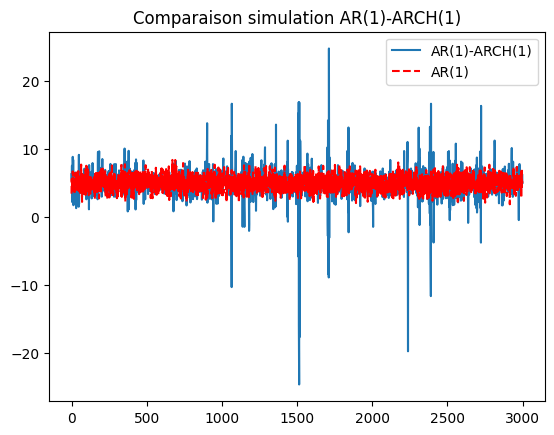

In [7]:
plt.title('Comparaison simulation AR(1)-ARCH(1)')

ar=simuler_arma(4000,5,[0.3],[],1)[1000:]
arch=simuler_ar_arch(4000,5,[0.3],[0.5,0.9],1)[1000:]

x=[i for i in range(3000)]
plt.plot(x,arch,label="AR(1)-ARCH(1)")
plt.plot(x, ar,"--",color="red",label="AR(1)") 
plt.legend()
plt.show()

Voici un zoom sur la série en ne représentant seulement les 100 dernières valeurs de la simulations.

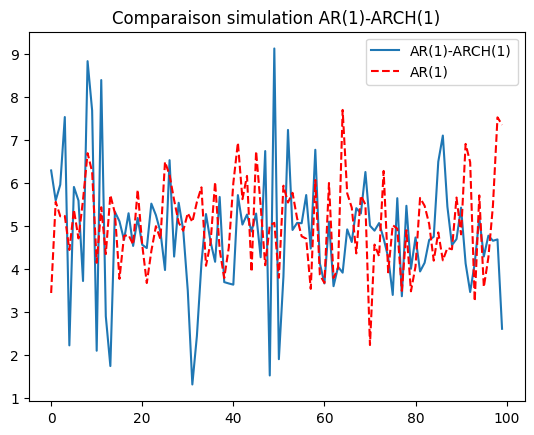

In [8]:
plt.title('Comparaison simulation AR(1)-ARCH(1)')
x=[i for i in range(100)]
plt.plot(x,arch[:100],label="AR(1)-ARCH(1)")
plt.plot(x, ar[:100],"--",color="red",label="AR(1)") 
plt.legend()
plt.show()

Simulation avec un arch

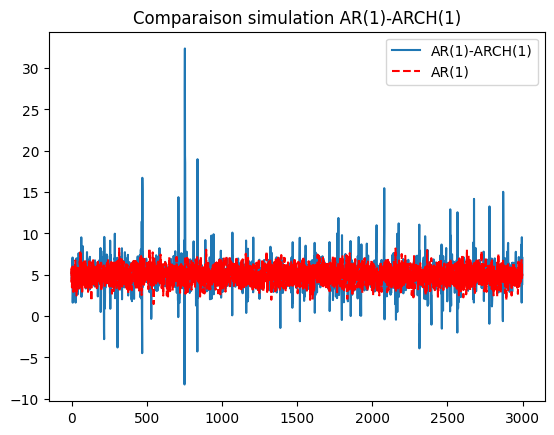

In [9]:
plt.title('Comparaison simulation AR(1)-ARCH(1)')

ar=simuler_arma(4000,5,[0.3],[],1)[1000:]
arch=simuler_arch(4000,5,[0.3],[0.5,0.9],1)[1000:]

x=[i for i in range(3000)]
plt.plot(x,arch,label="AR(1)-ARCH(1)")
plt.plot(x, ar,"--",color="red",label="AR(1)") 
plt.legend()
plt.show()

Par superposition, on peut constater visuellement que la modélisation AR(1) possède des pics bien plus petit que le processus AR(1)-ARCH(1). Ceci s'explique par le fait que l'AR se modélise autour de la moyenne et possède une variance conditionnelle constante. Ce qui n'est pas le cas pour l'AR(1)-ARCH(1). En effet, ce dernier prend en compte dans sa modélisation les variances aux passées, ce qui implique bien évidemment des pics plus variable dans la représentation.  

### II.1 Banque Argentine 

Ces données ont été récupéré sur Yahoo finance. Se sont des données mensuelles du 1er Janvier 2003 au 1er janvier 2022. Il s'agit des données de Grupo Financiero Galicia, une banque argentine fondée en 1905 et faisant partie du Merval, le principal indice boursier de la bourse de Buenos Aires.

In [10]:
df = pd.read_csv("GGAL_hebdo.csv")
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)
df['Adj Close'].plot()

FileNotFoundError: [Errno 2] No such file or directory: 'GGAL_hebdo.csv'

<AxesSubplot:xlabel='Date'>

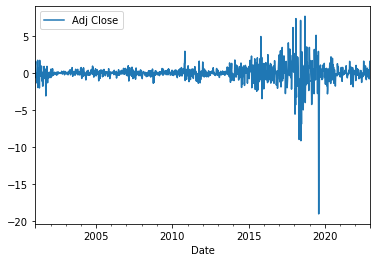

In [54]:
df2=df['Adj Close'].diff().dropna()
df2=pd.DataFrame(df2)
df2.plot()

##### Tentative modélisation ARMA

In [55]:
Mod = ARIMA(df2, order=(2, 0, 2)).fit()
print(Mod.params)

/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


const    -0.004109
ar.L1    -0.252162
ar.L2     0.446657
ma.L1     0.243473
ma.L2    -0.314679
sigma2    1.484846
dtype: float64


<AxesSubplot:xlabel='Date'>

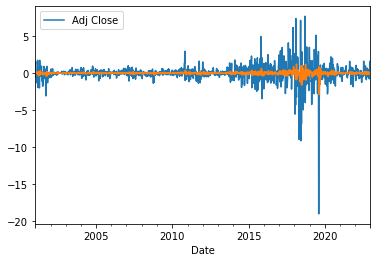

In [43]:
Fig = df2.plot()
Mod.fittedvalues.plot(ax = Fig)

On peut voir que la modélisation ne représente pas très bien la série. On tente néanmoins une prédiction. 

##### Prédictions

In [56]:
Ann2022 = df2[ (df2.index >= '2022') & (df2.index < '2023') ]

# On tronque sur la période 2001-2022
df_tronc = df2[ (df2.index >= '2001') & (df2.index < '2022') ]

Mod_tronc = ARIMA(df_tronc, order=(2, 0, 2)).fit()
print(Mod_tronc.params)

/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/lib64/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


const    -0.005196
ar.L1    -0.245123
ar.L2     0.447791
ma.L1     0.236459
ma.L2    -0.314807
sigma2    1.539051
dtype: float64


<AxesSubplot:xlabel='Date'>

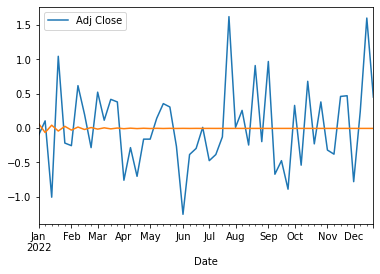

In [57]:
pred=Mod_tronc.get_forecast(steps=52).summary_frame(alpha=0.05)
fig=Ann2022.plot()
pred["mean"].plot(ax=fig)

##### Test modelisation ARCH-GARCH

In [58]:
mod_arch = arch_model(df2, vol="ARCH", p=1, q=0)
res = mod_arch.fit()
res.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5594.605884531125
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3772.497836517256
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1469.1419508933363
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1469.1492799165944
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1469.0780475481315
Iteration:      6,   Func. Count:     33,   Neg. LLF: 1469.078045247643
Iteration:      7,   Func. Count:     36,   Neg. LLF: 1469.078045750932
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1469.078045247643
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1469.08
Distribution:                  Normal   AIC:                           2944.16
Method:            Maximum Likelihood   BIC:                           2959.29
                                        No. Observations:                 1147
Date:                Wed, Jan 04 2023   Df Residuals:                     1146
Time:                        11:12:29   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0156  3.376e-02     -0.462      0.644 [-8.176e-02,5.058e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3682  6.610e-02      5.570  2.546e-08 [  0.239,  0.498]
alpha[1]       1.0000      0.192      5.198  2.015e-07 [  0.623,  1.377]
========================================================================

Covariance estimator: robust
"""

<AxesSubplot:xlabel='Date'>

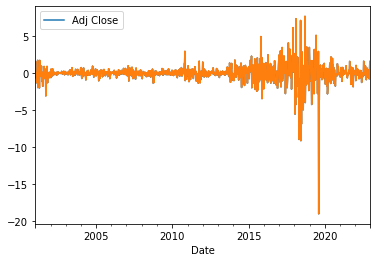

In [59]:
fig = df2.plot()
(res.resid).plot(ax=fig)

On peut voir que c'est tout de même mieux qu'une modélisation $ARMA$. Voyons comment ce modèle $ARCH(1)$ prédit les valeurs.

##### Prédictions $ARCH(1)$

Ceci est un test, nous n'arrivons pas à modéliser les prédictions de la série. Il semblerait qu'on ne puisse remodéliser seulement la volatilité. 

In [60]:
arch_tronc = arch_model(df_tronc, vol="ARCH", p=1, q=0)
res_tronc = arch_tronc.fit()
res_tronc.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5323.574128513719
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3078.5438560061375
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1415.6434181477302
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1415.5987895194546
Iteration:      5,   Func. Count:     28,   Neg. LLF: 1415.548046957692
Iteration:      6,   Func. Count:     32,   Neg. LLF: 1415.5479499570406
Iteration:      7,   Func. Count:     35,   Neg. LLF: 1415.547950526257
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1415.5479499570406
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1415.55
Distribution:                  Normal   AIC:                           2837.10
Method:            Maximum Likelihood   BIC:                           2852.09
                                        No. Observations:                 1095
Date:                Wed, Jan 04 2023   Df Residuals:                     1094
Time:                        11:13:42   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0175  3.473e-02     -0.503      0.615 [-8.553e-02,5.060e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3708  7.004e-02      5.294  1.199e-07 [  0.233,  0.508]
alpha[1]       1.0000      0.191      5.226  1.735e-07 [  0.625,  1.375]
========================================================================

Covariance estimator: robust
"""

In [61]:
pred_tronc=res_tronc.forecast(horizon=1)
print(pred_tronc.residual_variance)

                 h.1
Date                
2001-01-08       NaN
2001-01-15       NaN
2001-01-22       NaN
2001-01-29       NaN
2001-02-05       NaN
...              ...
2021-11-29       NaN
2021-12-06       NaN
2021-12-13       NaN
2021-12-20       NaN
2021-12-27  0.400453

[1095 rows x 1 columns]


/users/2023/ds2/118000246/.local/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [26]:
end = '2022-12-26'
start_date = np.datetime64('2022-01-03')
end_date = np.datetime64('2022-12-26')

start_end = np.array([start_date, end_date], dtype='datetime64')

dates = np.arange(start_date, end_date, dtype='datetime64[D]')

last_obs=end

In [38]:
res = mod_arch.fix(params=res.params, first_obs='2022-01-03', last_obs=end)

vol_fcast = res.forecast(horizon=1)
print(vol_fcast.residual_variance)

                 h.1
Date                
2001-01-08       NaN
2001-01-15       NaN
2001-01-22       NaN
2001-01-29       NaN
2001-02-05       NaN
...              ...
2022-11-28       NaN
2022-12-05       NaN
2022-12-12       NaN
2022-12-19  2.978334
2022-12-26  0.584976

[1147 rows x 1 columns]


/users/2023/ds2/118000246/.local/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


<AxesSubplot:xlabel='Date'>

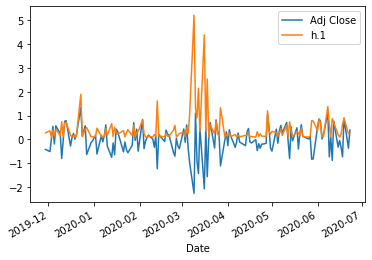

In [207]:
data_pred=df2.iloc[-142:,:]
fig=data_pred.plot()
vol_fcast.variance.iloc[-142:,:].plot(ax=fig)